# Modelling

## Packages

In [1]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import winsound
import datetime as dt

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder, normalize
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
import joblib

import xgboost

import tensorflow
from tensorflow.keras import layers
from tensorflow.keras import utils
from tensorflow.keras.models import load_model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.losses import CategoricalCrossentropy, BinaryCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy, BinaryAccuracy
#from tensorflow.nn import relu, softmax

from imblearn.over_sampling import SMOTE

from matplotlib import pyplot as plt

print(f" Found and Using {len(tensorflow.config.experimental.list_physical_devices('GPU'))} GPU")

 Found and Using 1 GPU


## Functions

In [17]:
def scale_x_encode_y(x, y):

    scaler_obj = StandardScaler()
    #scaler_obj = MinMaxScaler()
    scaler_obj.fit(x.values)
    x_scaled = scaler_obj.transform(x.values)
    #x_scaled = x.values
    
    encoder = LabelEncoder()
    encoder.fit(y)
    y_encoded = encoder.transform(y)
    y_encoded = utils.to_categorical(y_encoded)
    
    y_map = dict(zip(encoder.transform(encoder.classes_),encoder.classes_))
 
    return(x_scaled, y_encoded, y_map, scaler_obj)


def smote_data(x, y):
    oversample = SMOTE()
    smote_x, smote_y = oversample.fit_resample(x, y)

    return(smote_x, smote_y)

def split_data(df, divisor):
    df_tot = df.copy()
    print(f'df_tot count : {len(df_tot)}')

    df1 = df_tot.iloc[int(len(df_tot)/divisor):]
    print(f'df1 count : {len(df1)}')

    df2 = df_tot.iloc[:int(len(df_tot)/divisor)]
    print(f'df2 count : {len(df2)}')
    
    return(df_tot, df1, df2)

def data_prep(df, apply_smote = False):
    x = df.loc[:, df.columns != target_col]
    y = df[target_col]

    if apply_smote:
        x, y = smote_data(x, y)

    print(f'Record count : {len(y)}')
    print('--------------------------')
    print(y.value_counts())
    print('--------------------------')
    print(y.value_counts(normalize=True))
    
    x_scaled, y_encoded, y_map, scaler_obj = scale_x_encode_y(x, y)
    pd.DataFrame(x_scaled).head()
    
    return(x_scaled, y_encoded, y_map, scaler_obj)

## Read Data

In [18]:
remove_cols = ['tick_avg', 'sema', 'ssma', 'lema', 'lsma', 'max_tick', 'min_tick', 'small_sema_slope', 'long_sema_slope']

In [19]:
df = pd.read_csv('data/tab_tick_2019.csv')
df.drop(remove_cols, axis=1, inplace=True)
df.head(5)

,spread_avg,tick_sd,sema_diff,lema_diff,diff,avg_gain,avg_loss,rs,rsi,ssma_diff,lsma_diff,sma_diff,max_gap,min_gap,small_sema_slope,long_sema_slope,ema_diff,direction
0,0.000484,0.000021,0.000005,0.000003,-0.000023,0.000015,0.000010,1.510166,60.162003,7.250000e-07,2.015000e-06,-3.775000e-06,0.000023,-0.000104,-3.403495,-3.352386,0.000010,same
1,0.000563,0.000012,0.000008,0.000003,0.000031,0.000016,0.000010,1.667283,62.508663,3.212500e-06,2.980000e-06,-3.542500e-06,0.000000,-0.000135,-1.311670,-2.662815,0.000015,increase
2,0.000579,0.000017,0.000011,-0.000005,0.000027,0.000018,0.000010,1.837338,64.755700,5.000000e-06,1.265000e-06,1.925000e-07,0.000000,-0.000162,1.725139,-1.816549,0.000030,increase
3,0.000597,0.000010,0.000012,0.000002,0.000009,0.000018,0.000008,2.205128,68.800000,8.037500e-06,8.600000e-07,7.370000e-06,0.000000,-0.000172,5.227681,-0.784531,0.000040,same
4,0.000571,0.000010,0.000008,0.000001,-0.000027,0.000017,0.000010,1.632582,62.014483,7.225000e-06,2.550000e-07,1.434000e-05,0.000027,-0.000140,8.606636,0.402202,0.000046,same


In [20]:
target_col = 'direction'
x_scaled, y_encoded, y_map, scaler_obj = data_prep(df, apply_smote = False)
joblib.dump(scaler_obj, 'data/model/scaler_obj.pkl') 
joblib.dump(y_map, 'data/model/y_map.pkl') 

Record count : 49932
--------------------------
same        26930
increase    11545
decrease    11457
Name: direction, dtype: int64
--------------------------
same        0.539333
increase    0.231214
decrease    0.229452
Name: direction, dtype: float64


['data/model/y_map.pkl']

## Neural Network

### Network building

In [21]:
train_x, valid_x, train_y, valid_y = train_test_split(x_scaled, y_encoded,train_size = 0.8,random_state = 1)

In [22]:
model = Sequential([
    Dense(units = 2048, activation='relu', input_shape=(len(train_x[0]),)),
    Dense(units = 1024, activation='relu',),
    Dense(units = 512, activation='relu'),    
    Dense(units = 256, activation='relu'),
    Dense(units = 128, activation='relu'),
    Dense(units = 3, activation='softmax')
])

model.compile(    
    loss=CategoricalCrossentropy(),
    optimizer=Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, decay=0.01),
    metrics=CategoricalAccuracy())

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 2048)              36864     
_________________________________________________________________
dense_7 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dense_8 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_9 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_10 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_11 (Dense)             (None, 3)                 387       
Total params: 2,824,451
Trainable params: 2,824,451
Non-trainable params: 0
____________________________________________

### Training

In [23]:
epoch_val         = 10
batch_size_val    = 1024

verbose_val       = 2
workers_val       = -1

In [24]:
model.fit(x=train_x, 
          y=train_y, 
          epochs=epoch_val,
          batch_size = batch_size_val,
          validation_data = (valid_x, valid_y),
          workers= workers_val,
          verbose=verbose_val)

Epoch 1/10
40/40 - 2s - loss: 0.6885 - categorical_accuracy: 0.7613 - val_loss: 0.4616 - val_categorical_accuracy: 0.8130
Epoch 2/10
40/40 - 2s - loss: 0.4284 - categorical_accuracy: 0.8186 - val_loss: 0.4250 - val_categorical_accuracy: 0.8237
Epoch 3/10
40/40 - 2s - loss: 0.4059 - categorical_accuracy: 0.8281 - val_loss: 0.4113 - val_categorical_accuracy: 0.8290
Epoch 4/10
40/40 - 2s - loss: 0.3949 - categorical_accuracy: 0.8296 - val_loss: 0.4027 - val_categorical_accuracy: 0.8314
Epoch 5/10
40/40 - 2s - loss: 0.3875 - categorical_accuracy: 0.8339 - val_loss: 0.3982 - val_categorical_accuracy: 0.8337
Epoch 6/10
40/40 - 2s - loss: 0.3843 - categorical_accuracy: 0.8359 - val_loss: 0.3946 - val_categorical_accuracy: 0.8355
Epoch 7/10
40/40 - 2s - loss: 0.3799 - categorical_accuracy: 0.8374 - val_loss: 0.3930 - val_categorical_accuracy: 0.8348
Epoch 8/10
40/40 - 2s - loss: 0.3786 - categorical_accuracy: 0.8373 - val_loss: 0.3927 - val_categorical_accuracy: 0.8372
Epoch 9/10
40/40 - 2s - 

### DNN

In [25]:
predictions = model.predict(valid_x)
rounded_predictions = np.argmax(predictions, axis = -1)
rounded_valid_y = np.argmax(valid_y, axis = -1)

print(classification_report(rounded_valid_y, rounded_predictions, target_names = y_map.values()))

              precision    recall  f1-score   support

    decrease       0.85      0.78      0.81      2287
    increase       0.83      0.83      0.83      2332
        same       0.84      0.87      0.85      5368

    accuracy                           0.84      9987
   macro avg       0.84      0.82      0.83      9987
weighted avg       0.84      0.84      0.84      9987



In [26]:
model.save('data/model/model_dnn.h5') 
model_new = load_model('data/model/model_dnn.h5')

### DNN Prediction

Record count : 49932
--------------------------
same        20860
increase    14684
decrease    14388
Name: direction, dtype: int64
--------------------------
same        0.417768
increase    0.294080
decrease    0.288152
Name: direction, dtype: float64
              precision    recall  f1-score   support

    decrease       0.92      0.65      0.76     14388
    increase       0.92      0.67      0.78     14684
        same       0.66      0.92      0.77     20860

    accuracy                           0.77     49932
   macro avg       0.83      0.75      0.77     49932
weighted avg       0.81      0.77      0.77     49932



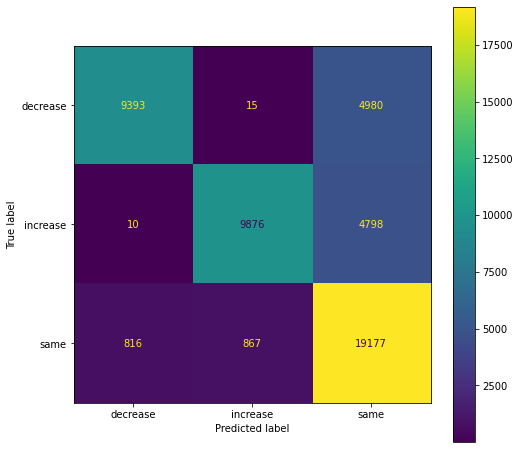

In [27]:
df1 = pd.read_csv('data/tab_tick_2018.csv')
df1.drop(remove_cols, axis=1, inplace=True)

x_scaled1, y_encoded1, y_map1, scaler_obj_1 = data_prep(df1, apply_smote = False)

predictions = model_new.predict(x_scaled1)
rounded_predictions = np.argmax(predictions, axis = -1)
rounded_valid_y = np.argmax(y_encoded1, axis = -1)

df1['predictions'] = [y_map1[k] for k in rounded_predictions]
df1.to_csv('data/tab_tick_2018_res.csv')

print(classification_report(rounded_valid_y, rounded_predictions, target_names = y_map1.values()))

fig, ax = plt.subplots(figsize=(8, 8))
cm = confusion_matrix(rounded_valid_y, rounded_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=y_map1.values())
disp.plot(ax=ax)

In [28]:
live_df = pd.read_csv('data/live_preds.csv')
live_df.drop(remove_cols, axis=1, inplace=True)
del live_df['predicted_direction']

model_new = load_model('data/model/model_dnn.h5')    
scaler_obj = joblib.load('data/model/scaler_obj.pkl')
y_map = joblib.load('data/model/y_map.pkl') 

x_scaled = scaler_obj.transform(live_df.values)
predictions = model_new.predict(x_scaled) 
rounded_predictions = np.argmax(predictions, axis = -1)

#live_df['predictions'] = y_map[data['rounded_predictions'][0]]
live_df['predictions'] = [y_map[k] for k in rounded_predictions]

print(y_map)
live_df['predictions'].value_counts()

ValueError: X has 15 features, but this StandardScaler is expecting 17 features as input.

## Random Forest

In [29]:
%%time
clf = RandomForestClassifier(n_jobs=-1) 
clf.fit(train_x, train_y)
joblib.dump(clf, 'data/model/model_rf.pkl') 

predictions = clf.predict(valid_x)
rounded_predictions = np.argmax(predictions, axis = -1)
rounded_valid_y = np.argmax(valid_y, axis = -1)
print(classification_report(rounded_valid_y, rounded_predictions, target_names = y_map.values()))

              precision    recall  f1-score   support

    decrease       0.81      0.81      0.81      2287
    increase       0.86      0.80      0.83      2332
        same       0.84      0.87      0.86      5368

    accuracy                           0.84      9987
   macro avg       0.84      0.83      0.83      9987
weighted avg       0.84      0.84      0.84      9987

Wall time: 5.69 s


Record count : 49932
--------------------------
same        20860
increase    14684
decrease    14388
Name: direction, dtype: int64
--------------------------
same        0.417768
increase    0.294080
decrease    0.288152
Name: direction, dtype: float64
              precision    recall  f1-score   support

    decrease       0.86      0.71      0.78     14388
    increase       0.93      0.68      0.79     14684
        same       0.69      0.90      0.78     20860

    accuracy                           0.78     49932
   macro avg       0.83      0.77      0.78     49932
weighted avg       0.81      0.78      0.78     49932



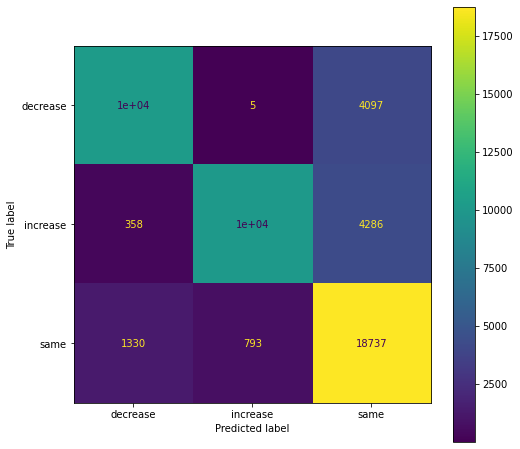

In [30]:
df1 = pd.read_csv('data/tab_tick_2018.csv')
df1.drop(remove_cols, axis=1, inplace=True)

x_scaled1, y_encoded1, y_map1, scaler_obj_1 = data_prep(df1, apply_smote = False)

clf_rf = joblib.load('data/model/model_rf.pkl') 
predictions = clf_rf.predict(x_scaled1)
rounded_predictions = np.argmax(predictions, axis = -1)
rounded_valid_y = np.argmax(y_encoded1, axis = -1)

df1['predictions'] = [y_map1[k] for k in rounded_predictions]
df1.to_csv('data/tab_tick_2018_res.csv')

print(classification_report(rounded_valid_y, rounded_predictions, target_names = y_map1.values()))

fig, ax = plt.subplots(figsize=(8, 8))
cm = confusion_matrix(rounded_valid_y, rounded_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=y_map1.values())
disp.plot(ax=ax)

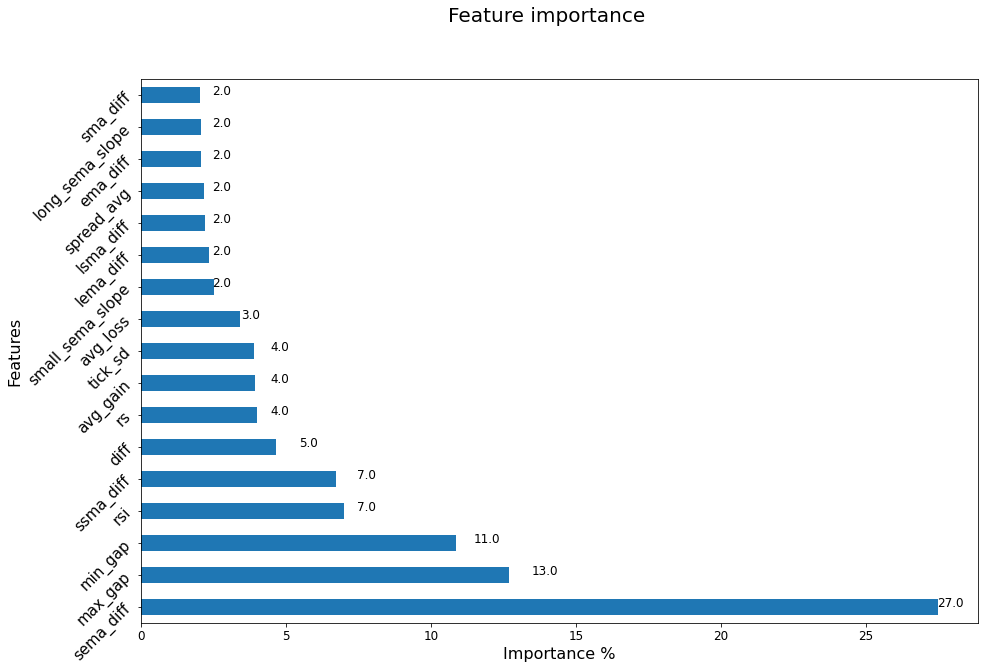

In [31]:
x_cols = df.columns[df.columns != 'direction']
fig = plt.figure()
fig.suptitle('Feature importance', fontsize=20)
plt.xlabel('Importance %', fontsize=16)
plt.ylabel('Features', fontsize=16)
plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=15)


feat_importances = pd.Series(clf_rf.feature_importances_ * 100, index=x_cols)
feat_importances.nlargest(30).plot(kind='barh', figsize=(15, 10), rot=45)

for index, value in enumerate(np.round(-np.sort(-clf.feature_importances_ * 100))):
    plt.text(value+0.45, index, str(value), fontsize=12)

In [ ]:
live_df = pd.read_csv('data/live_preds.csv')
live_df.drop(remove_cols, axis=1, inplace=True)
del live_df['predicted_direction']

scaler_obj = joblib.load('data/model/scaler_obj.pkl')
y_map = joblib.load('data/model/y_map.pkl') 
x_scaled = scaler_obj.transform(live_df.values)

predictions = clf_rf.predict(x_scaled)

rounded_predictions = np.argmax(predictions, axis = -1)

live_df['predictions'] = [y_map[k] for k in rounded_predictions]

print(y_map)
live_df['predictions'].value_counts()

## XGBOOST

In [42]:
%%time
clf_xg = xgboost.XGBClassifier()
rounded_train_y = np.argmax(train_y, axis = -1)
clf_xg.fit(train_x, rounded_train_y)
joblib.dump(clf_xg, 'data/model/model_xg.pkl') 
predictions = clf_xg.predict(valid_x)
rounded_valid_y = np.argmax(valid_y, axis = -1)
print(classification_report(rounded_valid_y, predictions, target_names = y_map.values()))

[09:38:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

    decrease       0.84      0.80      0.82      2319
    increase       0.84      0.80      0.82      2306
        same       0.83      0.87      0.85      5365

    accuracy                           0.84      9990
   macro avg       0.84      0.82      0.83      9990
weighted avg       0.84      0.84      0.84      9990

Wall time: 17.3 s


Record count : 49950
--------------------------
same        20862
increase    14685
decrease    14403
Name: direction, dtype: int64
--------------------------
same        0.417658
increase    0.293994
decrease    0.288348
Name: direction, dtype: float64
              precision    recall  f1-score   support

    decrease       0.29      1.00      0.45     14403
    increase       1.00      0.02      0.03     14685
        same       0.01      0.00      0.00     20862

    accuracy                           0.29     49950
   macro avg       0.43      0.34      0.16     49950
weighted avg       0.38      0.29      0.14     49950



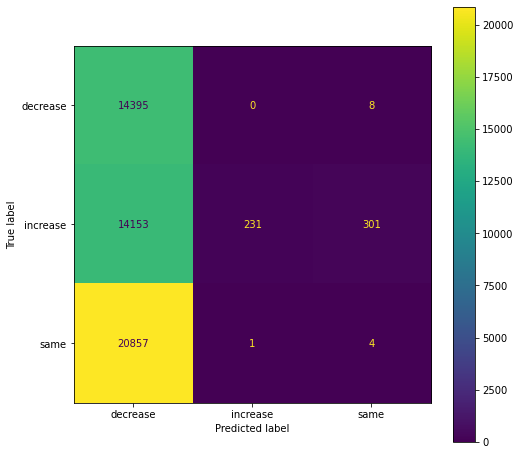

In [43]:
df1 = pd.read_csv('data/tab_tick_2018.csv')
df1.drop(remove_cols, axis=1, inplace=True)

x_scaled1, y_encoded1, y_map1, scaler_obj_1 = data_prep(df1, apply_smote = False)

clf_xg = joblib.load('data/model/model_xg.pkl') 
predictions = clf_xg.predict(x_scaled1)
rounded_valid_y = np.argmax(y_encoded1, axis = -1)

df1['predictions'] = [y_map1[k] for k in predictions]
df1.to_csv('data/tab_tick_2018_res.csv')

print(classification_report(rounded_valid_y, predictions, target_names = y_map1.values()))

fig, ax = plt.subplots(figsize=(8, 8))
cm = confusion_matrix(rounded_valid_y, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=y_map1.values())
disp.plot(ax=ax)

In [44]:
live_df = pd.read_csv('data/live_preds.csv')
live_df.drop(remove_cols, axis=1, inplace=True)
del live_df['predicted_direction']

scaler_obj = joblib.load('data/model/scaler_obj.pkl')
y_map = joblib.load('data/model/y_map.pkl') 
x_scaled = scaler_obj.transform(live_df.values)

predictions = clf_xg.predict(x_scaled)

live_df['predictions'] = [y_map[k] for k in predictions]

print(y_map)
live_df['predictions'].value_counts()

{0: 'decrease', 1: 'increase', 2: 'same'}


decrease    132
increase    108
same         43
Name: predictions, dtype: int64